# **Klasifikasi Diabetes Retinopati Menggunakan Metode EfficientNet B0**
---
Kelompok 4:

- Alya Fitri Nurhaliza (205150201111047)
- Zainiyah Nafiyatul Muna (205150201111030)

### Import Library & Data

In [3]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.transforms import ToPILImage
from PIL import Image
import gc
from tqdm import tqdm

In [4]:
data_dir = 'archive'

In [5]:
transformation = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

In [6]:
def merge_data(data_dir, transformation):
    all_datasets = []
    for folder in ['test', 'train']:
        path = os.path.join(data_dir, folder)
        dataset = datasets.ImageFolder(root=path, transform=transformation)
        all_datasets.append(dataset)

    combined_dataset = torch.utils.data.ConcatDataset(all_datasets)
    return combined_dataset

In [7]:
merged_data = merge_data(data_dir, transformation)

In [8]:
train_size = int(0.6 * len(merged_data))
val_size = int(0.2 * len(merged_data))
test_size = len(merged_data) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(merged_data, [train_size, val_size, test_size])

print('All data size: {},Train size: {}, Val size: {}, Test size: {}'.format(len(merged_data),
                                                                             train_size,
                                                                             val_size,
                                                                             test_size))

All data size: 3662,Train size: 2197, Val size: 732, Test size: 733


In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Create Model EfficientNet B0

In [12]:
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomEfficientNet, self).__init__()
        
        # Load pre-trained EfficientNet B0
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        
        # Modify the classification layer for the specific number of classes
        in_features = 1280
        self.efficientnet.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.efficientnet(x)

In [18]:
custom_model = CustomEfficientNet(num_classes=5)

In [22]:
models.efficientnet_b0(pretrained=True)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### Training Model

In [15]:
def train(model, train_loader, criterion, optimizer, num_epochs, patience):
    model.train()
    global best_loss
    global counter
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Print training statistics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

        # Check if the validation loss has improved
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            counter = 0
        else:
            counter += 1

        # Early stopping condition
        if counter >= patience:
            print("Early stopping! Training will stop.")
            break

In [20]:
# Early stopping parameters
patience = 5  # Number of epochs with no improvement after which training will stop
best_loss = float('inf')
counter = 0

In [21]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(custom_model.parameters(), lr=0.001, momentum=0.9)

# Training parameters
num_epochs = 100  # Adjust as needed

# Start training
train(custom_model, train_loader, criterion, optimizer, num_epochs, patience)

Epoch 1/100, Loss: 1.0788, Accuracy: 59.72%
Epoch 2/100, Loss: 0.7809, Accuracy: 71.55%
Epoch 3/100, Loss: 0.7032, Accuracy: 73.60%
Epoch 4/100, Loss: 0.6515, Accuracy: 75.51%
Epoch 5/100, Loss: 0.6154, Accuracy: 77.38%
Epoch 6/100, Loss: 0.5708, Accuracy: 77.70%
Epoch 7/100, Loss: 0.5347, Accuracy: 79.65%
Epoch 8/100, Loss: 0.5217, Accuracy: 79.47%
Epoch 9/100, Loss: 0.4656, Accuracy: 82.34%
Epoch 10/100, Loss: 0.4482, Accuracy: 81.70%
Epoch 11/100, Loss: 0.4075, Accuracy: 84.16%
Epoch 12/100, Loss: 0.3912, Accuracy: 85.75%
Epoch 13/100, Loss: 0.3574, Accuracy: 86.94%
Epoch 14/100, Loss: 0.3418, Accuracy: 87.80%
Epoch 15/100, Loss: 0.3153, Accuracy: 89.03%
Epoch 16/100, Loss: 0.2896, Accuracy: 90.26%
Epoch 17/100, Loss: 0.2760, Accuracy: 90.99%
Epoch 18/100, Loss: 0.2441, Accuracy: 92.13%
Epoch 19/100, Loss: 0.2318, Accuracy: 92.67%
Epoch 20/100, Loss: 0.2184, Accuracy: 93.45%
Epoch 21/100, Loss: 0.2018, Accuracy: 93.54%
Epoch 22/100, Loss: 0.1841, Accuracy: 94.90%
Epoch 23/100, Loss:

### Model Evaluation

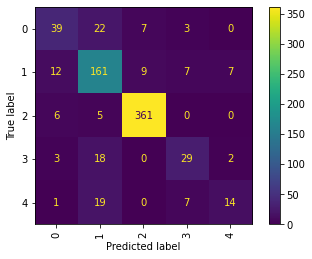

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make sure the model is in evaluation mode
custom_model.eval()

# Initialize lists to store ground truth and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to gather predictions
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = custom_model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
labels = [str(i) for i in range(5)]  # Replace with your class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='viridis', values_format='d', xticks_rotation='vertical')

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Make sure the model is in evaluation mode
custom_model.eval()

# Initialize lists to store ground truth and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to gather predictions
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = custom_model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.8251
Precision: 0.8191
Recall: 0.8251
F1 Score: 0.8185
Confusion Matrix:
[[ 39  22   7   3   0]
 [ 12 161   9   7   7]
 [  6   5 361   0   0]
 [  3  18   0  29   2]
 [  1  19   0   7  14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.55      0.59        71
           1       0.72      0.82      0.76       196
           2       0.96      0.97      0.96       372
           3       0.63      0.56      0.59        52
           4       0.61      0.34      0.44        41

    accuracy                           0.83       732
   macro avg       0.71      0.65      0.67       732
weighted avg       0.82      0.83      0.82       732



### Model Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


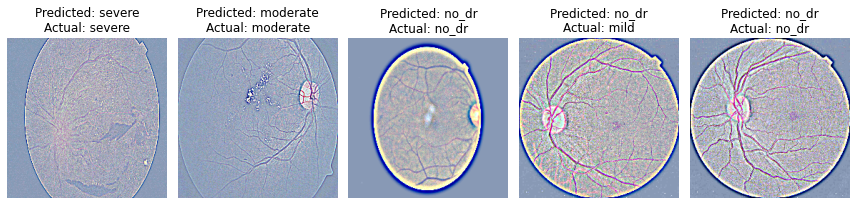

In [30]:
import matplotlib.pyplot as plt

# Choose five random images from the test loader
sample_data, sample_target = next(iter(test_loader))

# Perform inference
with torch.no_grad():
    model_output = custom_model(sample_data)

# Convert the output to predicted labels
predicted_labels = model_output.argmax(dim=1)

# Display the images and predicted labels
num_images_to_display = 5
class_names = ['mild', 'moderate', 'no_dr', 'severe', 'proliferative']

plt.figure(figsize=(12, 4))  # Adjust figure size for readability

for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    
    image = sample_data[i].permute(1, 2, 0).numpy()
    image = (image * 0.5) + 0.5  # Denormalize if you used Normalize((0.5,), (0.5,))
    
    pred_label = class_names[predicted_labels[i]]
    true_label = class_names[sample_target[i]]
    
    plt.imshow(image)
    plt.title(f"Predicted: {pred_label}\nActual: {true_label}", fontsize=12)  # Smaller font size
    plt.axis('off')  # Disable axes for a cleaner display

plt.tight_layout()
plt.show()